# Differentiating between different types of leukocytes

This project concerns itself with identifying leukocytes (white blood cells) in an image of a blood sample and aims to differentiate between their different types. It is formatted akin to a case study, showing a possible path for biology-related research.

Although all leukocytes participate on the protection of our bodies from pathogens, the different groups have widly different functions and it is thus important to be able to discern between them if we want to study our immune responses. A sufficiently accurate automation tool could be used to speed up analyses of human samples.

In [305]:
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [306]:
LABEL_PATH = "data/labels.csv"
IMAGE_PATH = "data/images"
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Dataset overview and cleaning

Some information about the [dataset](https://www.kaggle.com/paultimothymooney/blood-cells):

- the dataset consist of 367 annotated images of blood samples
- most of the images contain exactly one white blood cell of a certain type
    - eosinophils, lymphocytes, monocytes, neutrophils, and basophils
- each image in the dataset has an accompanying label specifying which type of cell it shows


Note that there is an alternative dataset with augmented data and some additional annotations, but we won't use it to simulate more typical research conditions, and we will do the object selection and augmentation ourselves.

We first load the images and their annotations and show the distribution of the cell types.

In [480]:
def load_image(path):
    try:
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    except:
        return None


data = pd.read_csv(LABEL_PATH)[["Image", "Category"]]
data = data.rename(columns={"Category": "label", "Image": "id"})
data = data[-pd.isna(data["label"])]

data["path"] = [f"data/images/BloodImage_{id:05}.jpg" for id in data["id"]]

data["image"] = [load_image(path) for path in data["path"]]
data = data[[im is not None for im in data["image"]]]

data["label"].value_counts()

NEUTROPHIL                206
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   20
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,EOSINOPHIL       1
LYMPHOCYTE, LYMPHOCYTE      1
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: label, dtype: int64

You can see examples of the images below.

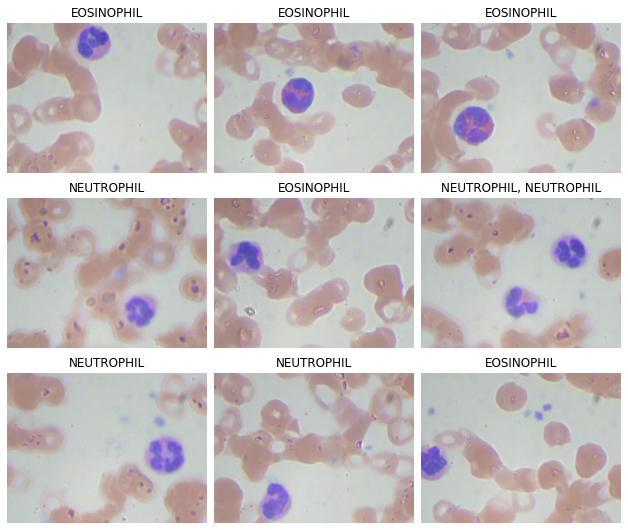

In [481]:
def plot_grid(images, titles=None, title=None, cmap=None, top=1.15):
    if titles is None:
        titles = [None] * len(images)
        padding = 0.1
    else:
        padding = (0.1, 0.35)

    fig = plt.figure(figsize=(11, 11))
    if title is not None:
        fig.suptitle(title)
        fig.subplots_adjust(top=top)
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=padding)
    for ax, img, title in zip(grid, images, titles):
        if title is not None:
            ax.set_title(title)
        ax.axis("off")
        ax.imshow(img, cmap=cmap)


# The following are used for demostration purposes troughout this notebook
n = 9
IMAGES, TITLES = data["image"][55 : 55 + n], data["label"][55 : 55 + n]

plot_grid(images=IMAGES, titles=TITLES)


Some of the images contain more than one cell, as you can see above. We will filter out such cases; however, for reasons that will become apparent later, we keep do images that contain two of the same type of leukocyte and only change their labels.

In [482]:
def relabel(label):
    if "," in label:
        l1, l2 = label.split(",")
        return l1 if l1 == l2 else None
    else:
        return label


data["label"] = [relabel(l) for l in data["label"]]
data = data[[l is not None for l in data["label"]]]
data["label"].value_counts()

NEUTROPHIL    207
EOSINOPHIL     89
LYMPHOCYTE     33
MONOCYTE       20
BASOPHIL        3
Name: label, dtype: int64

## Leukocyte isolation by image segmentation with OpenCV

Apart from leukocytes, there are other cells in the samples. Crop the images so that only the leukocytes remain will provide cleaner data to our model which should make for a faster training and more accurate predictions.

We could do this image segmentation by utilising another DNN model, but we will use OpenCV instead to demostrate its power.

We notice that the images can be divided to three parts:
1. The gray background.
2. The small erytrocytes, whose colour is leaning toward red hues.
3. Finally, the leukocytes, whose colour has a strong blue component.

We will construct simple masks to filter out (1) and (2) to be left only with the leukocytes. Firstly, let's write a function to detect the background.

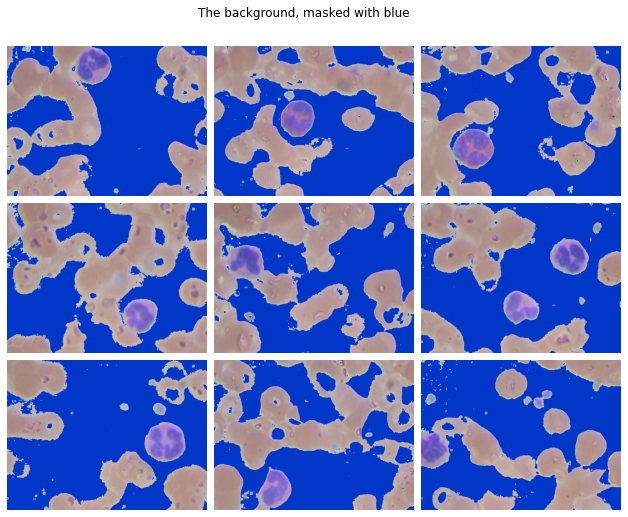

In [483]:
# Some custom colors for labelling
RED, GREEN, BLUE = (200, 55, 0), (0, 200, 55), (0, 55, 200)

def visualize_mask(img, mask, color=(255, 255, 255), no_bg=False):
    i = img.copy()
    i[mask(img)] = color
    if no_bg:
        i[~mask(img)] = (0, 0, 0)
    return i

def is_background(img):
    return (img[:, :, 0] > 180) & (img[:, :, 1] > 180) & (img[:, :, 2] > 180)


plot_grid(
    images=[visualize_mask(img, is_background, BLUE) for img in IMAGES],
    title="The background, masked with blue",
)

Now, the erytrocytes, added on top of the masked background. Their colors have a really low blue component, or have a stronger red than blue component.

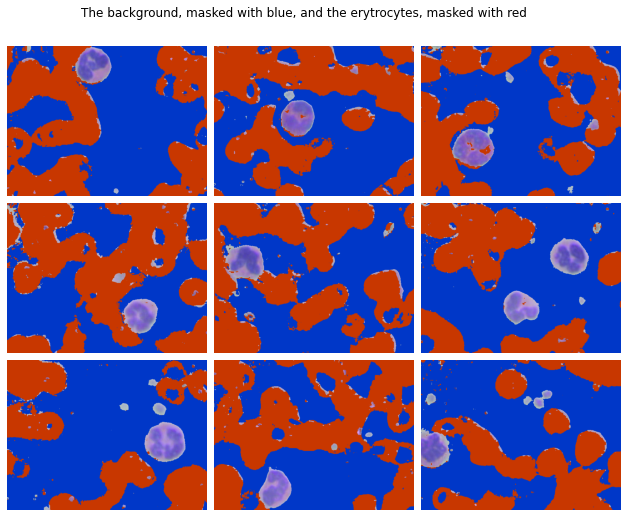

In [484]:
def is_erytrocyte(img):
    return (img[:, :, 2] < 150) | (img[:, :, 0] + 3 > img[:, :, 2])


plot_grid(
    images=[
        visualize_mask(visualize_mask(img, is_background, BLUE), is_erytrocyte, RED)
        for img in IMAGES
    ],
    title="The background, masked with blue, and the erytrocytes, masked with red",
)

The leukocyte masks themselves look like the following.

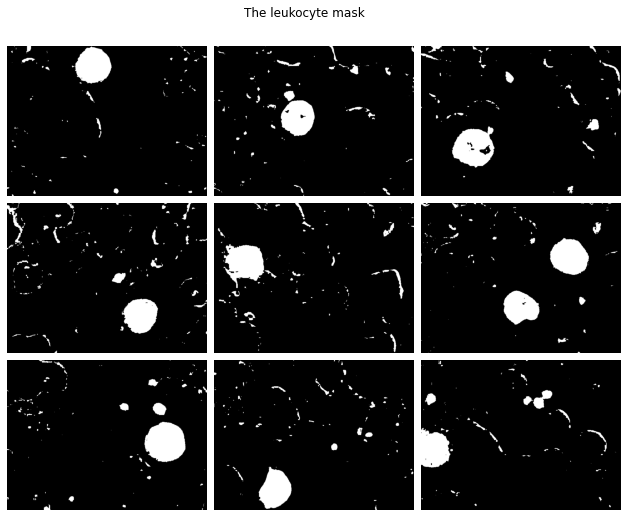

In [485]:
def is_leukocyte(img):
    return ~is_background(img) & ~is_erytrocyte(img)


plot_grid(
    images=[visualize_mask(img, is_leukocyte, no_bg=True) for img in IMAGES],
    title="The leukocyte mask",
)

You can see that we're left with the leukocyte, save for a few small scraps. Now we need to do the following:
1. Get rid of the little scraps and round off the leukocyte mask.
2. Find the bounding boxes of the leukocytes.
3. Then, finally, crop them.

First, let's find round off the leukocyte mask by running a few iterations of an _opening_ operation, i.e. errosion (basically removal of thin lines) followed by dilation (thickening the remaining lines).

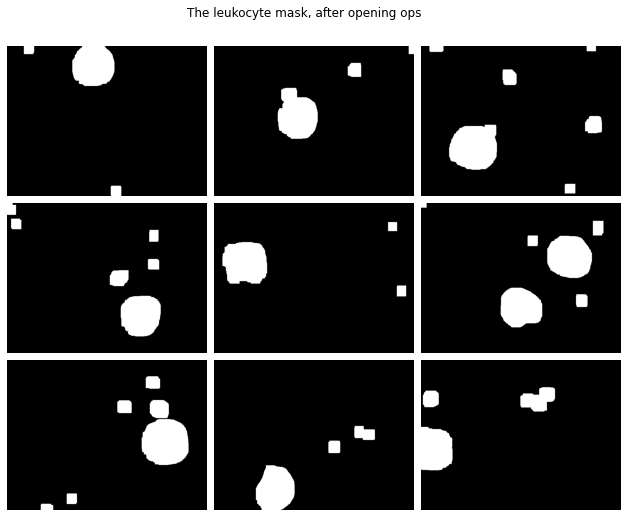

In [486]:
def leukocyte_mask(img):
    i = cv2.GaussianBlur(img, (21, 21), 2)
    i = visualize_mask(img, is_leukocyte, no_bg=True)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    i = cv2.erode(i, kernel, iterations=2)
    i = cv2.dilate(i, kernel, iterations=7)

    return np.max(i.astype(np.uint8), axis=2)


plot_grid(
    images=[leukocyte_mask(img) for img in IMAGES],
    title="The leukocyte mask, after opening ops",
    cmap="gray"
)

It is now trivial to find the contours and bounding boxes of the leukocytes, because they are currently the biggest unmasked area of the image. Notice that when two leukocytes are present, only the larger is selected. This explains why we kept samples with two leukocytes of the same type --- we can be sure that the label is correct no matter which of them is selected in this step.

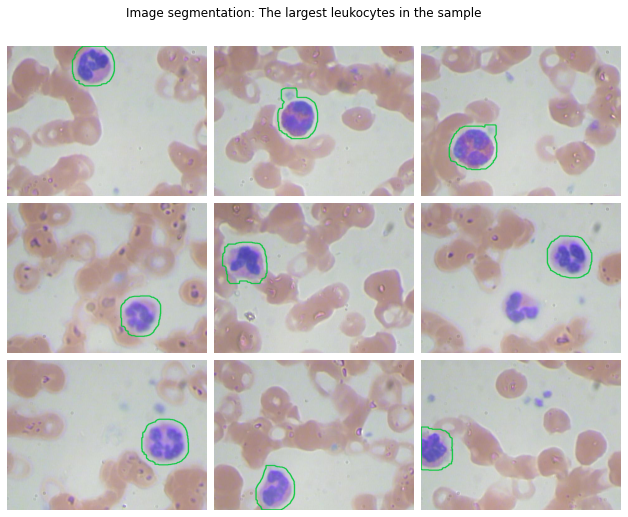

In [487]:
def area(c):
    rect = cv2.boundingRect(c)
    return rect[2] * rect[3]


def find_contours(img_thr):
    contours, _ = cv2.findContours(
        img_thr, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE
    )
    return sorted(contours, key=area, reverse=True)


def draw_contours(img, contours, which=-1, color=GREEN):
    im = img.copy()
    return cv2.drawContours(
        im, contours, contourIdx=which, color=color, thickness=2, lineType=cv2.LINE_AA
    )


CONTOURS = [find_contours(leukocyte_mask(img)) for img in IMAGES]

plot_grid(
    images=[draw_contours(img, cont, which=0) for img, cont in zip(IMAGES, CONTOURS)],
    title="Image segmentation: The largest leukocytes in the sample",
)


We will now proceed to crop the cells. We could just mask off the remainders of the image, but by cropping we will save some space without affecting the performance of the model. First, we need to compute the bounding boxes of the leukocytes.

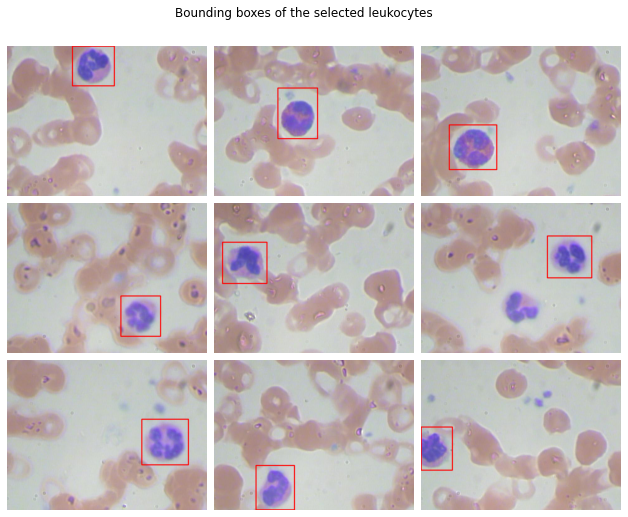

In [488]:
def box(contour):
    return np.int0(cv2.boxPoints(cv2.minAreaRect(contour)))


plot_grid(
    images=[
        draw_contours(img, [box(cs[0])], color=(255, 0, 0))
        for img, cs in zip(IMAGES, CONTOURS)
    ],
    title="Bounding boxes of the selected leukocytes",
)

Now we can crop the cells right around their bounding box, and resize them to fit a `128 x 128` square, stretching them if necessary. This constitutes the second-to-last part of our data preparation pipeline, the last being data augmentation.

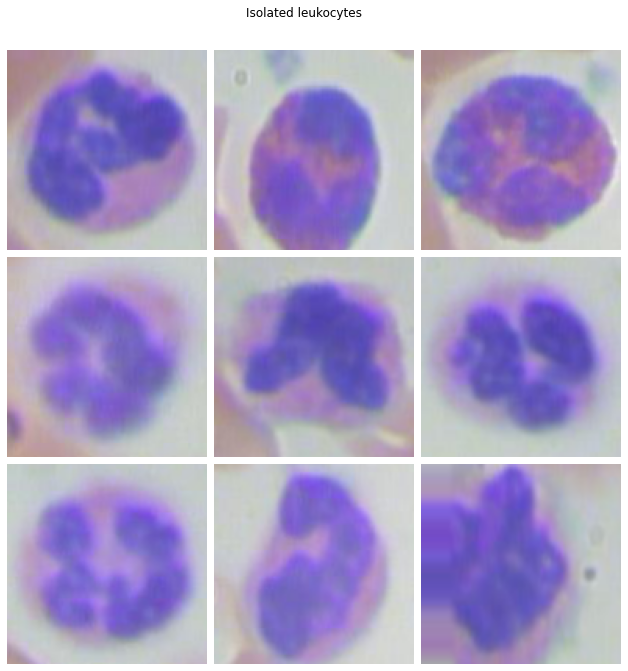

In [518]:
def crop(src, contour):
    # Get center, size, and angle from rect
    center, size, theta = cv2.minAreaRect(contour)
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D(center, 4 * theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, (src.shape[1] ,src.shape[0]))
    out = cv2.getRectSubPix(dst, size, center)
    return out

plot_grid(
    images=[
        cv2.resize(crop(img, cs[0]), (128, 128))
        for img, cs in zip(IMAGES, CONTOURS)
    ],
    title="Isolated leukocytes",
    top=0.95
)

We add these images to our original dataset, as we will use them for the model training.

In [501]:
def isolate_cell(image, size=128):
    contours = find_contours(leukocyte_mask(image))
    padded = cv2.resize(crop(image, contours[0]), (size, size))
    return padded

data["cell"] = [isolate_cell(im) for im in data["image"]]

## Data augmentation

In [300]:
SEED = 42

class_names = data["label"].unique()

cells = [np.asarray(c) for c in data["cell"]]
# targets = [np.argmax(l == data["label"].unique()) for l in data["label"]]
targets = [int(l == "NEUTROPHIL") for l in data["label"]]

## Model definition and training

In [301]:
from sklearn.model_selection import train_test_split

data_rest, data_test, targets_rest, targets_test = train_test_split(
    cells, targets, test_size=0.1, stratify=targets)

data_train, data_dev, targets_train, targets_dev = train_test_split(
    data_rest, targets_rest, train_size=0.85, stratify=targets_rest
)

train = tf.data.Dataset.from_tensor_slices((data_train, targets_train)).batch(32)
dev = tf.data.Dataset.from_tensor_slices((data_dev, targets_dev)).batch(32)
test = tf.data.Dataset.from_tensor_slices((data_test, targets_test))

In [302]:
input = layers.Input((128, 128, 3))

h = layers.Conv2D(16, 3, padding='same', activation='relu')(input)
h = layers.MaxPooling2D()(h)
h = layers.Conv2D(32, 3, padding='same', activation='relu')(h)
h = layers.MaxPooling2D()(h)
h = layers.Conv2D(64, 3, padding='same', activation='relu')(h)
h = layers.MaxPooling2D()(h)
h = layers.Flatten()(input)
h = layers.Dense(128, activation='relu')(h)

output = layers.Dense(len(class_names), activation="softmax")(h)

model = tf.keras.Model(inputs=[input], outputs=[output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
history = model.fit(train, validation_data=dev, epochs=30)

Epoch 1/30
1/9 [==>...........................] - ETA: 2s - loss: 332.9523 - sparse_categorical_accuracy: 0.0000e+00

2022-01-03 18:55:53.048515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 52ms/step - loss: 3514.1702 - sparse_categorical_accuracy: 0.4888 - val_loss: 2598.4158 - val_sparse_categorical_accuracy: 0.4167
Epoch 2/30
1/9 [==>...........................] - ETA: 0s - loss: 2593.3240 - sparse_categorical_accuracy: 0.4062

2022-01-03 18:55:53.544185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 38ms/step - loss: 1128.1543 - sparse_categorical_accuracy: 0.5112 - val_loss: 976.1144 - val_sparse_categorical_accuracy: 0.4167
Epoch 3/30
9/9 [==============================] - 0s 39ms/step - loss: 1609.0228 - sparse_categorical_accuracy: 0.5261 - val_loss: 1152.0615 - val_sparse_categorical_accuracy: 0.5833
Epoch 4/30
9/9 [==============================] - 0s 38ms/step - loss: 1854.0760 - sparse_categorical_accuracy: 0.4888 - val_loss: 492.0337 - val_sparse_categorical_accuracy: 0.3958
Epoch 5/30
9/9 [==============================] - 0s 39ms/step - loss: 1018.4010 - sparse_categorical_accuracy: 0.5597 - val_loss: 3254.3350 - val_sparse_categorical_accuracy: 0.4167
Epoch 6/30
9/9 [==============================] - 0s 38ms/step - loss: 2647.9368 - sparse_categorical_accuracy: 0.5597 - val_loss: 5166.3369 - val_sparse_categorical_accuracy: 0.4167
Epoch 7/30
9/9 [==============================] - 0s 38ms/step - loss: 3918.9746 - sparse_categori

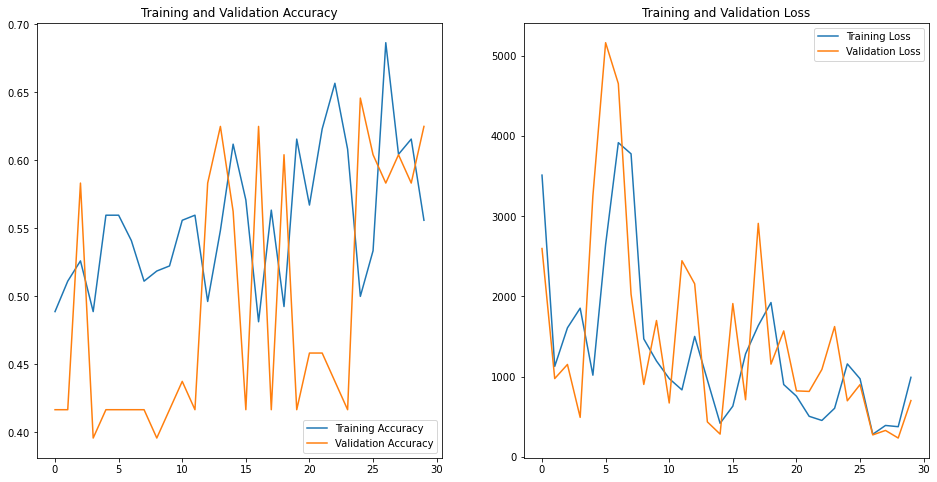

In [303]:
epochs_range = range(30)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [304]:
np.argmax(model.predict(test.batch(2)), axis=1)

2022-01-03 18:56:22.574390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [288]:
tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices((data_train, targets_train)).batch(32)).numpy()

9